In [70]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.offline import *
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [71]:
repo = ('https://iowa-hp.s3.us-west-1.amazonaws.com/merge_data_update.csv')

housing1 = pd.read_csv(repo, skipinitialspace=True)
housing1 = housing1.drop(['Unnamed: 0'], 1)

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('mode.chained_assignment',None)
np.set_printoptions(threshold=9999999)

Data Summary

In [72]:
def DataSummary(df):

	summary = pd.DataFrame({'Features': df.columns,'Datatypes': [df.dtypes[i] for i in range(len(df.columns))],
		'Nulls':[df[df.columns[i]].isnull().sum() for i in range(len(df.columns))]})

	return print(summary)

housing1_summary = DataSummary(housing1)

         Features Datatypes  Nulls
0             PID     int64      0
1       GrLivArea     int64      0
2       SalePrice     int64      0
3      MSSubClass     int64      0
4        MSZoning    object      0
5     LotFrontage   float64    462
6         LotArea     int64      0
7          Street    object      0
8           Alley    object   2412
9        LotShape    object      0
10    LandContour    object      0
11      Utilities    object      0
12      LotConfig    object      0
13      LandSlope    object      0
14   Neighborhood    object      0
15     Condition1    object      0
16     Condition2    object      0
17       BldgType    object      0
18     HouseStyle    object      0
19    OverallQual     int64      0
20    OverallCond     int64      0
21      YearBuilt     int64      0
22   YearRemodAdd     int64      0
23      RoofStyle    object      0
24       RoofMatl    object      0
25    Exterior1st    object      0
26    Exterior2nd    object      0
27     MasVnrType   

Missing values

Missing at Random (MAR) values: Lot frontage. Use averages from a combination of the shape of the lot and the area of the lot to impute missing values with buckets. Missing Not at Random (MNAR) values: No basement. Fill with None. Missing Completely at Random (MCAR) values: Electrical, etc. Fill with mean / mode of feature.

In [73]:
# LotFrontage: replace with bucket means of LotArea and LotShape, if missing values occur in reference dictionary, impute using averages of LotArea bucket

housing1['LotAreaBucks'] = pd.qcut(housing1['LotArea'], 20, labels=False)

lotfront_dict1 = housing1.groupby(['LotAreaBucks','LotShape']).mean().to_dict()
idx_n = housing1.LotFrontage.isnull()
housing1.loc[idx_n, 'LotFrontage'] = housing1[idx_n].apply(lambda x: lotfront_dict1['LotFrontage'].get((x['LotAreaBucks'],x['LotShape'])), axis=1)

lotfront_dict2 = housing1.groupby(['LotAreaBucks']).mean().to_dict()
idx_n2 = housing1.LotFrontage.isnull()
housing1.loc[idx_n2, 'LotFrontage'] = housing1[idx_n2].apply(lambda x: lotfront_dict2['LotFrontage'].get((x['LotAreaBucks'])), axis=1)

housing1 = housing1.drop(['LotAreaBucks'],1)

In [74]:
# # Basement: where consistent with MNAR logic, impute with 'None'
# # NOTE: THIS DATA IS NOT ACCURATE

idx_bsmtnone = housing1.BsmtQual.isnull()
bsmtnone_lst = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

for i in bsmtnone_lst:
    housing1.loc[idx_bsmtnone, i] = 'None'

In [75]:
# The rest: fill MNAR with None, MAR and MCAR with mean and mode

housing1.fillna({
    'Alley':'None',
    'MasVnrType':'None',
    'MasVnrArea':'None',
    'BsmtFinSF1':housing1.BsmtFinSF1.mean(),
    'BsmtFinSF2':housing1.BsmtFinSF2.mean(),
    'BsmtUnfSF':housing1.BsmtUnfSF.mean(),
    'TotalBsmtSF':housing1.TotalBsmtSF.mean(),
    'BsmtExposure':housing1.BsmtExposure.mode()[0],
    'BsmtFinType2':housing1.BsmtFinType2.mode()[0],
    'Electrical':housing1.Electrical.mode()[0]
}, inplace=True)

In [76]:
# Basement data were not correctly assigned by the person writing in this data.

# Consider the following rows, 4:8.
# In three, the SF for all basements is 0. So one would believe there are no basements in these houses.
# However, look at Basmenet Quality, Condition, and Exposure. They are rated as if basements were there when the realtors showed these units.
# This pattern is consistent throughout the data.

housing1[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1']][4:8]


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1
4,Gd,TA,No,GLQ,643.0
5,None,None,None,None,0.0
6,Fa,TA,No,Unf,0.0
7,Gd,TA,Gd,Unf,0.0


In [77]:
#Solution: if a house includes a Finished Basement, we assume that the realtor would want to includw this asset.
# The alternative is a lower-valued property, and less money in the realtor's pocket.
# We assume realtors are rational human beings (a dangerous assumption).
# Edit: this is indeed too much to ask. False values exist (high occurange of values 0-25) when indicated Basement Area. See code in cell below.

# To remedy this, we do not use exisitng columns on BsmtQual, Condition, Exposure, etc. Instead, we create a variable that measure Total Square Footage of Finished Basement Space
# --> create variable "Finished Basement SF" that adds up SF of basement when there is a FinType better than Unf.

housing1['BsmtLivArea'] = np.zeros(len(housing1))

housing1['BsmtLivArea'][(housing1.BsmtFinType1 != 'Unf')] = housing1.BsmtFinSF1
housing1['BsmtLivArea'][(housing1.BsmtFinType2 != 'Unf')] = housing1.BsmtFinSF2
housing1['BsmtLivArea'][(housing1.BsmtFinType2 != 'Unf') & (housing1.BsmtFinType2 != 'Unf')] = housing1.BsmtFinSF1 + housing1.BsmtFinSF2


In [78]:
housing1[(housing1.BsmtLivArea != 0) & (housing1.BsmtLivArea < 25)][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1
10,Gd,TA,No,GLQ,24.0
26,Gd,TA,Av,GLQ,16.0
184,Gd,TA,Av,GLQ,24.0
202,Gd,TA,Av,GLQ,24.0
269,Gd,Gd,Mn,GLQ,24.0
303,Gd,TA,Mn,GLQ,24.0
434,Gd,TA,No,GLQ,24.0
443,Gd,TA,No,GLQ,24.0
616,Gd,TA,No,GLQ,24.0
654,TA,TA,Mn,GLQ,24.0


In [79]:
fig = px.histogram(housing1, x='BsmtFinSF1')
iplot(fig)

Note: basement variables may not be reliable

In [80]:
# Basement baths - replace with mean based on Basement living area

housing1['BsmtLivAreaBucks'] = pd.cut(housing1['BsmtLivArea'], 10, labels=False)

BsmtBath_dict = housing1.groupby(['BsmtLivAreaBucks']).median().to_dict()

idx_n3 = housing1.BsmtFullBath.isnull()

housing1.loc[idx_n3, 'BsmtFullBath'] = housing1[idx_n3].apply(lambda x: BsmtBath_dict['BsmtFullBath'].get((x['BsmtLivAreaBucks'])), axis=1)
housing1.loc[idx_n3, 'BsmtHalfBath'] = housing1[idx_n3].apply(lambda x: BsmtBath_dict['BsmtHalfBath'].get((x['BsmtLivAreaBucks'])), axis=1)

housing1 = housing1.drop(['BsmtLivAreaBucks'],1)

In [81]:
housing2 = housing1.copy()

In [82]:
# Fireplaces - MNAR, NaN represents no fireplace

idx_f0 = housing1.Fireplaces == 0

housing2.loc[idx_f0, 'FireplaceQu'] = 'None'

In [83]:
# Garagetype (1) - MNAR, NaN represents no garage

idx_g0 = housing1.GarageArea == 0

garag_lst2 = ['GarageType','GarageFinish','GarageQual','GarageCond']

housing2.loc[idx_g0, garag_lst2] = 'None'


In [84]:
# Garagetype (2) MAR, encode as ordinal to impute median

dict_qual = {'None':0, 'Po':1, 'Fa':2, 'TA':3,'Gd':4,'Ex':5}
gr_fin = {'None':0,'Unf':1,'RFn':2,'Fin':3}


def OrdinalEncoding(df, multcols, dic):

	for i in multcols:
		df[str(i)] = df[str(i)].map(dic)

	return df

housing2 = OrdinalEncoding(housing2, ['GarageQual','GarageCond'], dict_qual)
housing2 = OrdinalEncoding(housing2, ['GarageFinish'], gr_fin)


In [85]:
# impute median 

Garage_dict = housing2.groupby(['GarageType']).median().to_dict()

idx_n5 = housing2.GarageCond.isnull()

garage_lst = ['GarageQual','GarageCond','GarageFinish','GarageCars','GarageArea']


for i in garage_lst:
    housing2.loc[idx_n5, i] = housing2[idx_n5].apply(lambda x: Garage_dict[str(i)].get((x['GarageType'])), axis=1)

In [86]:
# Note: it is impossible for this data to have imputed values and still be correct.
#median year imputed as a result (lwo number of entries, unimportant feature)

housing2.fillna({
    'GarageYrBlt':housing2.GarageYrBlt.median()
}, inplace=True)

In [87]:
#PoolQC, Fence, MiscFeatures

housing2.fillna({
    'PoolQC':'None',
    'Fence':'None',
    'MiscFeature':'None'
}, inplace=True)

In [88]:
# ClassPr_S

housing2.ClassPr_S = housing2.ClassPr_S.fillna(housing2.ClassPr_S.mode()[0])


In [89]:
# ClassPr_S
# How does one impute mode from a group of categoricals?


In [90]:
# LndAc_S

housing2['GrLivAreaBucks'] = pd.qcut(housing1['GrLivArea'], 20, labels=False)

grliv_dict = housing2.groupby(['GrLivAreaBucks']).mean().to_dict()

idx_n7 = housing2.LndAc_S.isnull()

housing2.loc[idx_n7, 'LndAc_S'] = housing2[idx_n7].apply(lambda x: grliv_dict['LndAc_S'].get((x['GrLivAreaBucks'])), axis=1)


In [91]:
# OthAc_S

housing2['GrLivAreaBucks'] = pd.qcut(housing1['GrLivArea'], 20, labels=False)

grliv_dict = housing2.groupby(['GrLivAreaBucks']).mean().to_dict()

idx_n7 = housing2.OthAc_S.isnull()

housing2.loc[idx_n7, 'OthAc_S'] = housing2[idx_n7].apply(lambda x: grliv_dict['OthAc_S'].get((x['GrLivAreaBucks'])), axis=1)


In [92]:
#GLA

housing2['GrLivAreaBucks'] = pd.qcut(housing2['GrLivArea'], 30, labels=False)

grliv_dict = housing2.groupby(['GrLivAreaBucks']).mean().to_dict()

idx_n6 = housing2.GLA.isnull()

housing2.loc[idx_n6, 'GLA'] = housing2[idx_n6].apply(lambda x: grliv_dict['GLA'].get((x['GrLivAreaBucks'])), axis=1)



In [93]:
#drop columns with too much NaN data / data that is definitively not useful

housing2 = housing2.drop(['ZngOLPr','ZngOLSc','SchD_S','TxD_S','ImpAc_S','HSTtl_D','HSTtl_S'], 1)

In [94]:
def DataSummary(df):

	summary = pd.DataFrame({'Features': df.columns,'Datatypes': [df.dtypes[i] for i in range(len(df.columns))],
		'Nulls':[df[df.columns[i]].isnull().sum() for i in range(len(df.columns))]})

	return print(summary)

housing2_summary = DataSummary(housing2)

          Features Datatypes  Nulls
0              PID     int64      0
1        GrLivArea     int64      0
2        SalePrice     int64      0
3       MSSubClass     int64      0
4         MSZoning    object      0
5      LotFrontage   float64      0
6          LotArea     int64      0
7           Street    object      0
8            Alley    object      0
9         LotShape    object      0
10     LandContour    object      0
11       Utilities    object      0
12       LotConfig    object      0
13       LandSlope    object      0
14    Neighborhood    object      0
15      Condition1    object      0
16      Condition2    object      0
17        BldgType    object      0
18      HouseStyle    object      0
19     OverallQual     int64      0
20     OverallCond     int64      0
21       YearBuilt     int64      0
22    YearRemodAdd     int64      0
23       RoofStyle    object      0
24        RoofMatl    object      0
25     Exterior1st    object      0
26     Exterior2nd    object

In [21]:
housing2[::500]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,GeoRefNo,Prop_Addr,ZngCdPr,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,SchD_S,TxD_S,LndAc_S,ImpAc_S,OthAc_S,HSTtl_D,HSTtl_S,GLA,BsmtLivArea,GrLivAreaBucks
0,909176150,856,126000,30,RL,63.821429,7890,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,1.0,2.0,399.0,3.0,3.0,Y,0,0,0,0,166,0,None,None,None,0,3,2010,WD,Normal,909176150.0,909176150.0,436 HAYWARD AVE,RL,NaN,NaN,RESIDENTIAL,1-STORY 1945 & OLDER,1.0,1.0,37300.0,0.0,111700.0,NaN,NaN,856.0,238.0,1
500,903226130,1324,128000,50,RM,50.000000,6000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,4,6,1936,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,BLQ,672.0,Unf,0.0,0.0,672.0,GasA,TA,Y,SBrkr,757,567,0,0.0,0.0,1,0,3,1,TA,6,Typ,0,None,Detchd,1936.0,1.0,1.0,240.0,3.0,3.0,Y,0,0,0,0,0,0,None,None,None,0,7,2009,WD,Normal,903226130.0,903226130.0,1210 CURTISS AVE,UCRM,NaN,NaN,RESIDENTIAL,1-1/2 STORY FINISHED ALL AGES,1.0,1.0,38800.0,0.0,116500.0,NaN,NaN,1324.0,672.0,12
1000,907250050,2000,305900,20,RL,80.000000,10386,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,CemntBd,CmentBd,Stone,246.0,Gd,TA,PConc,Gd,TA,No,GLQ,1464.0,Unf,0.0,536.0,2000.0,GasA,Ex,Y,SBrkr,2000,0,0,1.0,0.0,2,0,3,1,Gd,8,Typ,0,None,Attchd,2004.0,3.0,3.0,888.0,3.0,3.0,Y,168,0,0,0,0,0,None,None,None,0,7,2007,WD,Normal,907250050.0,907250050.0,517 SMILEY AVE,RL,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,1.0,1.0,91600.0,0.0,274800.0,4850.0,4850.0,2003.0,1464.0,25
1500,527276150,864,141000,20,RL,140.000000,19138,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,1Story,4,5,1951,1951,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,LwQ,120.0,Unf,0.0,744.0,864.0,GasA,Ex,Y,SBrkr,864,0,0,0.0,0.0,1,0,2,1,TA,4,Typ,0,None,Detchd,1951.0,1.0,2.0,400.0,3.0,3.0,Y,0,0,0,0,0,0,None,None,None,0,6,2010,WD,Normal,527276150.0,527276150.0,917 TOP O HOLLOW RD,RL,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,5.0,45.0,36400.0,0.0,109100.0,NaN,NaN,864.0,120.0,1
2000,909475140,1801,289000,20,RL,100.000000,15602,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1Story,7,8,1959,1997,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1247.0,Unf,0.0,254.0,1501.0,GasA,TA,Y,SBrkr,1801,0,0,1.0,0.0,2,0,1,1,TA,6,Typ,2,TA,Attchd,1959.0,3.0,2.0,484.0,3.0,3.0,Y,0,54,0,0,161,0,None,GdWo,None,0,3,2010,WD,Normal,909475140.0,909475140.0,2100 ASHMORE DR,RL,NaN,NaN,RESIDENTIAL,1-STORY 1946 & NEWER ALL STYLES,1.0,1.0,80200.0,0.0,240500.0,4850.0,4850.0,1801.0,1247.0,23
2500,534252090,999,178400,85,RL,87.000000,12122,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,SFoyer,7,9,1961,2007,Gable,CompShg,CemntBd,CmentBd,Stone,210.0,Ex,TA,CBlock,TA,TA,Av,ALQ,867.0,Unf,0.0,77.0,944.0,GasA,Gd,Y,SBrkr,999,0,0,1.0,0.0,1,0,3,1,Ex,6,Typ,0,None,Attchd,1961.0,2.0,2.0,588.0,3.0,3.0,Y,144,76,0,0,0,0,None,None,None,0,7,2008,WD,Normal,534252090.0,534252090.0,2207 MELROSE AVE,RL,NaN,NaN,RESIDENTIAL,SPLIT FOYER,1.

In [22]:
housing2['OthAc_S'].value_counts()

156100.0    8
131800.0    8
123100.0    7
129400.0    7
131200.0    7
135900.0    7
142000.0    7
123400.0    6
168600.0    6
129100.0    6
130600.0    6
120400.0    6
155500.0    6
112300.0    6
109300.0    6
160000.0    6
152400.0    6
116500.0    6
108400.0    6
120700.0    6
104500.0    5
127000.0    5
105100.0    5
114500.0    5
118900.0    5
139900.0    5
150100.0    5
120100.0    5
156700.0    5
127900.0    5
142300.0    5
132700.0    5
123700.0    5
121200.0    5
112900.0    5
133600.0    5
177400.0    5
124500.0    5
110400.0    5
113200.0    5
131700.0    5
155800.0    5
105700.0    5
161800.0    5
130000.0    5
137900.0    5
164400.0    5
103900.0    5
109900.0    5
169600.0    5
171400.0    5
138500.0    5
146200.0    5
138100.0    5
130400.0    5
112000.0    5
183700.0    4
126100.0    4
143300.0    4
119200.0    4
108700.0    4
203100.0    4
179300.0    4
134400.0    4
128200.0    4
149800.0    4
157100.0    4
198100.0    4
173800.0    4
146100.0    4
125500.0    4
115000

In [23]:
fig = px.scatter(housing2, x='LndAc_S',y='OthAc_S')
iplot(fig)

Encoding categoricals.

This section splits all nominals into a sparse matrix, and all ordonals into a mapping of values based on their quality.

Summary: data looks good. Interesting areas include Zoning, Neighborhood (location), Quality and Condition of house (qual), and others. Stay away from any basement variables. This may be simpler than it looks.

In [24]:
# set a copy of the dataframe
housing2_5 = housing2.copy()


In [25]:
# onehot encode

multcols1 = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Heating','CentralAir','Electrical']

def OneHot_Fast(df, multcols):	

	multOneHot = pd.DataFrame(OneHotEncoder().fit_transform(df[multcols].astype(str)).toarray(),
		columns = [i for j in [[str(j) + '_' + str(i) for i in np.unique(df[j].astype(str).values)] for j in multcols] for i in j])
    
	df['newID'], multOneHot['newID'] = range(len(df)),range(len(multOneHot))

	return df.drop([k for k in multcols], 1).merge(multOneHot).drop(['newID'], 1)

housing2 = OneHot_Fast(housing2, multcols1)

In [26]:
# Label encoding


dict_qual = {'None':0, 'Po':1, 'Fa':2, 'TA':3,'Gd':4,'Ex':5}
ordinal_qual = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual']

# NOTE: BSMT DATA IS NOT ACCURATE
dict_exposure = {'None':0, 'No':0, 'Mn':1, 'Av':2,'Gd':3,'Ex':4}
ordinal_exposure = ['BsmtExposure','FireplaceQu']

dict_finish = {'None':0, 'Unf':0, 'LwQ':1, 'Rec':2,'BLQ':3,'ALQ':4,'GLQ':5}
ordinal_finish = ['BsmtFinType1','BsmtFinType2']

pv_drive = {'Y':1,'N':0,'P':0}
ordinal_pave = ['PavedDrive']

found_dict = {'CBlock':1, 'PConc':2,'BrkTil':1, 'Slab':1,'Stone':1,'Wood':1}
ordinal_found = ['Foundation']

def OrdinalEncoding(df, multcols, dic):

	for i in multcols:
		df[str(i)] = df[str(i)].map(dic)

	return df

housing2 = OrdinalEncoding(housing2, ordinal_qual, dict_qual)
housing2 = OrdinalEncoding(housing2, ordinal_exposure, dict_exposure)
housing2 = OrdinalEncoding(housing2, ordinal_finish, dict_finish)
housing2 = OrdinalEncoding(housing2, ordinal_pave, pv_drive)
housing2 = OrdinalEncoding(housing2, ordinal_found, found_dict)

In [27]:
housing2[:5]

,PID,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,GeoRefNo,Prop_Addr,ZngCdPr,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,SchD_S,TxD_S,LndAc_S,ImpAc_S,OthAc_S,HSTtl_D,HSTtl_S,GLA,BsmtLivArea,GrLivAreaBucks,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr
0,909176150,856,126000,63.821429,7890,6,6,1939,1950,0.0,3,3,1,3,3,0,2,238.0,0,0.0,618.0,856.0,3,856,0,0,1.0,0.0,1,0,2,1,3,4,Typ,1,3.0,Detchd,1939.0,1.0,2.0,399.0,3.0,3.0,1,0,0,0,0,166,0,None,None,None,0,3,2010,WD,Normal,909176150.0,909176150.0,436 HAYWARD AVE,RL,NaN,NaN,RESIDENTIAL,1-STORY 1945 & OLDER,1.0,1.0,37300.0,0.0,111700.0,NaN,NaN,856.0,238.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Feature creation. 

With Preprocessing done, we can begin to add in the necessary features / features that might help us predict the price. Exploration stage.

In [28]:
### Price adjusted for inflation

# retrieve data from US Bureau of Labor Statistics
repo = ('https://download.bls.gov/pub/time.series/cu/cu.data.12.USHousing')

cpi1 = pd.read_csv(repo, skipinitialspace=True, sep='\t')

# Segment data by correct "series id" (season id "CUSR0000SAH" = "Housing in U.S. city average, all urban consumers, seasonally adjusted")
cpi2 = cpi1[cpi1['series_id        '] == 'CUSR0000SAH      ']


# Adjust time series to match our data
cpi2['period'] = pd.Series([i[1:] for i in cpi2['period']]).astype(int)
cpi2 = cpi2[(cpi2.year > 2005) & (cpi2.year < 2011)]


In [29]:
# Calculate inflation rate with base period as January 2006. Store data in a dictionary by year-month match
cpi3 = cpi2.groupby(['year', 'period']).agg({'value':np.mean}).reset_index()
cpi3['infl_rate'] = (cpi3['value'] - cpi3.loc[0, 'value']) / cpi3.loc[0, 'value']
cpi_dict = cpi3.groupby(['year','period']).mean().to_dict()


In [30]:
# map inflation rate to dataframe

for i in housing2.index:
    housing2.loc[i, 'infl_rate'] = cpi_dict['infl_rate'].get((housing2.loc[i, ['YrSold']][0], housing2.loc[i, ['MoSold']][0]))

In [31]:
# confirm values were copied correctly
housing2[['YrSold','MoSold','infl_rate']][:5]

,YrSold,MoSold,infl_rate
0,2010,3,0.078035
1,2009,2,0.085102
2,2007,11,0.056678
3,2009,5,0.082244
4,2009,11,0.082105


In [32]:
# Add the new feature: Sales Price Adjusted for Inflation. 

housing2['AdjSalePrice'] = housing2['SalePrice'] * (1 - housing2['infl_rate'])


In [33]:
#Add another new feature: House Age

housing2['HouseAge'] = ((housing2['YrSold'] - housing2['YearBuilt']) * (2/3)) + ((housing2['YrSold'] - housing2['YearRemodAdd']) * (1/3))

In [34]:
# Try two different quality scores, one good and one bad, and asses their performance during EA.
# Note: this is based on how we interpret "Overall Quality" vs "Overall Condition". My hunch is that the "Condition" variable fluctuates by row due to data input errors. Quality seems to fluctuate much less so.

housing2['QualScore'] = housing2.OverallQual * housing2.GrLivArea

housing2['QualScore_comparison'] = housing2.OverallCond * housing2.GrLivArea

In [35]:
# Add in a feature for Exterior quality. Consider how the house looks when someone drives up to it; what it is made of, first impressions, etc.

housing2['ExtScore'] = housing2['ExterQual'] * housing2['Foundation']

In [36]:
# Add in a feature for Garage

housing2['GarageScore'] = housing2['GarageCars'] * housing2['GarageArea']

In [37]:
# Add in a feature for Kitechen

housing2['KitchenScore'] = housing2['KitchenAbvGr'] * housing2['KitchenQual']

In [38]:
#Add in a feature for all baths

housing2['AllBaths'] = housing2['BsmtFullBath'] + housing2['BsmtHalfBath'] + housing2['FullBath'] + housing2['HalfBath']

In [39]:
housing3 = housing2.copy()

In [40]:
housing3[:5]

,PID,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,GeoRefNo,Prop_Addr,ZngCdPr,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,SchD_S,TxD_S,LndAc_S,ImpAc_S,OthAc_S,HSTtl_D,HSTtl_S,GLA,BsmtLivArea,GrLivAreaBucks,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,infl_rate,AdjSalePrice,HouseAge,QualScore,QualScore_comparison,ExtScore,GarageScore,KitchenScore,AllBaths
0,909176150,856,126000,63.821429,7890,6,6,1939,1950,0.0,3,3,1,3,3,0,2,238.0,0,0.0,618.0,856.0,3,856,0,0,1.0,0.0,1,0,2,1,3,4,Typ,1,3.0,Detchd,1939.0,1.0,2.0,399.0,3.0,3.0,1,0,0,0,0,166,0,None,None,None,0,3,2010,WD,Normal,909176150.0,909176150.0,436 HAYWARD AVE,RL,NaN,NaN,RESIDENTIAL,1-STORY 1945 & OLDER,1

Outliars. 

This section details how we could identify and remove about 25 outliars from the data. This data is mostly higher values with correspondingly higher sales prices. However, after doing a prelim score with / without outliars, it appears that the model performs better when no outliars are removed. We add the outliars in.

In [41]:
### Possible outliar suspects:

# AdjSalePrice - sale price
# GrLivArea - total living area, in sq footage
# LotArea - total lot area, in sq footage
# LotFrontage - how much of the lot area touches the street

col_lst = ['AdjSalePrice','GrLivArea','LotArea','LotFrontage','BsmtLivArea']

for i in col_lst:
    fig = px.histogram(housing3, x=i)
    fig.update_layout({'title':{'text':i}})
    iplot(fig)

In [42]:
housing3.describe()

,PID,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MapRefNo,GeoRefNo,SchD_S,TxD_S,LndAc_S,ImpAc_S,OthAc_S,HSTtl_D,HSTtl_S,GLA,BsmtLivArea,GrLivAreaBucks,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,infl_rate,AdjSalePrice,HouseAge,QualScore,QualScore_comparison,ExtScore,GarageScore,KitchenScore,AllBaths
count,2.580000e+03,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.000000,2580.00000,2580.000000,2580.000000,2580.000000,1895.000000,2580.000000,25

In [43]:
housing3[(housing3.GrLivArea > 3300)]
housing3[(housing3.LotFrontage > 180)]
housing3[(housing3.LotArea > 70000)]
housing3[(housing3.BsmtLivArea > 2000)]
#

,PID,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,GeoRefNo,Prop_Addr,ZngCdPr,ZngOLPr,ZngOLSc,ClassPr_S,ClassSc_S,SchD_S,TxD_S,LndAc_S,ImpAc_S,OthAc_S,HSTtl_D,HSTtl_S,GLA,BsmtLivArea,GrLivAreaBucks,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSewr,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,infl_rate,AdjSalePrice,HouseAge,QualScore,QualScore_comparison,ExtScore,GarageScore,KitchenScore,AllBaths
65,528164060,2470,615000,106.0,12720,10,5,2003,2003,680.0,5,3,2,5,3,3,5,2257.0,0,0.0,278.0,2535.0,5,2470,0,0,2.0,0.0,1,1,1,1,5,7,Typ,2,3.0,Attchd,2003.0,3.0,3.0,789.0,3.0,3.0,1,154,65,0,0,216,144,Ex,None,None,0,2,2008,WD,Normal,528164060.0,528164060.0,3320 FOXLEY DR,FS-RL,NaN,NaN,RESIDENTIAL,1-STORY 1946

In [44]:
# Remove this line from the code.
# housing3 = housing3.drop(housing3[(housing2.LotArea > 70000) | (housing3.GrLivArea > 3300) | (housing3.LotFrontage > 180) | (housing3.BsmtLivArea > 2000)].index)

In [45]:
# Remove this line from the code.
# # Cut 25 observations

# print(len(housing2))
# print(len(housing3))

Quick jump-start on the EA in R - there appears to be a solid relationship in Neighborhood and MSZoning categories with Sale Price. Maybe there's a cleaner way to see the data?

In [46]:
fig = px.scatter_3d(housing1, x='Neighborhood', y='MSZoning', z='SalePrice')
iplot(fig)

Preliminary score.

Messing around with new features // seeing how it impacts R2

In [47]:
housing5 = housing3.copy()

In [48]:
def MergeOnCols(df1, df2):
    
    df1['newID'], df2['newID'] = range(len(df1)), range(len(df2))
    
    return df1.merge(df2, on='newID').drop(['newID'], 1)

housing4 = MergeOnCols(housing5, housing1[['Neighborhood','MSZoning']])

In [49]:
housing4['PavedDrive'] = housing2['PavedDrive']

In [50]:
# housing4 = housing4[['AdjSalePrice','GrLivArea','BsmtLivArea','QualScore','Neighborhood','MSZoning','HouseAge','FullBath','GarageScore','ExterQual']]
housing4 = housing4[['AdjSalePrice','GrLivArea','BsmtLivArea','QualScore','HouseAge','GarageScore',
                     'Neighborhood','MSZoning','PavedDrive',
                     'ExtScore','GLA','GarageScore',
                     'AllBaths'
#                      'KitchenScore','FullBath','GarageScore',
                    ]]

In [51]:
housing4['Location'] = housing4['Neighborhood'] + '_' + housing4['MSZoning']
housing4['Location_pv'] = housing4['Location'] + '_' + housing4['PavedDrive'].astype(str)
housing4 = housing4.drop(['Neighborhood','MSZoning','Location','PavedDrive'], 1)

In [52]:
multcols1 = ['Location_pv']

def OneHot_Fast(df, multcols):	

	multOneHot = pd.DataFrame(OneHotEncoder().fit_transform(df[multcols].astype(str)).toarray(),
		columns = [i for j in [[str(j) + '_' + str(i) for i in np.unique(df[j].astype(str).values)] for j in multcols] for i in j])
    
	df['newID'], multOneHot['newID'] = range(len(df)),range(len(multOneHot))

	return df.drop([k for k in multcols], 1).merge(multOneHot).drop(['newID'], 1)

housing4 = OneHot_Fast(housing4, multcols1)

In [53]:
def StandardizeColumn(df, col):

	df[str(col)] = ((df[str(col)] - np.mean(df[str(col)])) / (df[str(col)].std()))

	return df[str(col)]


housing4['AdjSalePrice'] = StandardizeColumn(housing4, 'AdjSalePrice')


In [54]:
housing4[:5]

,AdjSalePrice,GrLivArea,BsmtLivArea,QualScore,HouseAge,GarageScore,ExtScore,GLA,AllBaths,Location_pv_Blmngtn_RL_1,Location_pv_Blmngtn_RM_1,Location_pv_Blueste_RM_1,Location_pv_BrDale_RM_1,Location_pv_BrkSide_RL_0,Location_pv_BrkSide_RL_1,Location_pv_BrkSide_RM_0,Location_pv_BrkSide_RM_1,Location_pv_ClearCr_RL_0,Location_pv_ClearCr_RL_1,Location_pv_CollgCr_RL_1,Location_pv_CollgCr_RM_1,Location_pv_Crawfor_RH_1,Location_pv_Crawfor_RL_0,Location_pv_Crawfor_RL_1,Location_pv_Crawfor_RM_1,Location_pv_Edwards_RH_1,Location_pv_Edwards_RL_0,Location_pv_Edwards_RL_1,Location_pv_Edwards_RM_1,Location_pv_Gilbert_RL_0,Location_pv_Gilbert_RL_1,Location_pv_Greens_RL_1,Location_pv_GrnHill_RM_1,Location_pv_IDOTRR_C (all)_0,Location_pv_IDOTRR_C (all)_1,Location_pv_IDOTRR_I (all)_0,Location_pv_IDOTRR_RM_0,Location_pv_IDOTRR_RM_1,Location_pv_Landmrk_RH_1,Location_pv_MeadowV_RM_1,Location_pv_Mitchel_A (agr)_0,Location_pv_Mitchel_RL_0,Location_pv_Mitchel_RL_1,Location_pv_Mitchel_RM_1,Location_pv_NAmes_RH_1,Location_pv_NAmes_RL_0,Location_pv_NAmes_RL_1,Location_pv_NPkVill_RL_1,Location_pv_NWAmes_RL_1,Location_pv_NoRidge_RL_1,Location_pv_NridgHt_RL_1,Location_pv_NridgHt_RM_1,Location_pv_OldTown_C (all)_0,Location_pv_OldTown_C (all)_1,Location_pv_OldTown_RL_0,Location_pv_OldTown_RL_1,Location_pv_OldTown_RM_0,Location_pv_OldTown_RM_1,Location_pv_SWISU_RH_0,Location_pv_SWISU_RH_1,Location_pv_SWISU_RL_0,Location_pv_SWISU_RL_1,Location_pv_SawyerW_RH_0,Location_pv_SawyerW_RH_1,Location_pv_SawyerW_RL_0,Location_pv_SawyerW_RL_1,Location_pv_Sawyer_RL_0,Location_pv_Sawyer_RL_1,Location_pv_Sawyer_RM_1,Location_pv_Somerst_FV_1,Location_pv_Somerst_RL_1,Location_pv_StoneBr_RL_1,Location_pv_Timber_RL_0,Location_pv_Timber_RL_1,Location_pv_Veenker_RL_1
0,-0.725879,856,238.0,5136,67.333333,798.0,3,856.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.564110,1049,945.0,5245,25.000000,266.0,4,1049.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.702543,1001,737.0,5005,51.333333,216.0,4,1001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.888816,1039,0.0,4156,74.666667,281.0,4,1039.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.575461,1665,643.0,13320,8.000000,1056.0,8,1665.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Quick peek to see what the score might be, based on current data

In [55]:
#train test split

import random

random.seed(42)

data = housing4.drop(['AdjSalePrice'],1)
target = housing4[['AdjSalePrice']]

idx = np.random.choice(range(0,len(housing4)), size=round(len(housing4)*0.75), replace=False)

train_x = data.iloc[idx]
train_y = target.iloc[idx]

test_x = data.iloc[~idx]
test_y = target.iloc[~idx]


In [56]:
# rf model, no grid search
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.set_params(random_state=42)

rf.fit(train_x, train_y.squeeze())

print("The training error is: %.5f" % (1 - rf.score(train_x, train_y)))
print("The test     error is: %.5f" % (1 - rf.score(test_x, test_y)))
print("the training score is:", rf.score(train_x, train_y).round(5))
print("the test     score is:", rf.score(test_x, test_y).round(5))

The training error is: 0.01953
The test     error is: 0.03878
the training score is: 0.98047
the test     score is: 0.96122


In [57]:
train_scr = []
test_scr = []

for i in range(30):

    rf = RandomForestRegressor()
    
    rf.fit(train_x, train_y.squeeze())
    
    train_scr.append(rf.score(train_x, train_y))
    test_scr.append(rf.score(test_x, test_y))


In [58]:
fig = px.line(x=range(30), y=test_scr)
fig.update_layout(yaxis_range=[0.95,1.00])
iplot(fig)


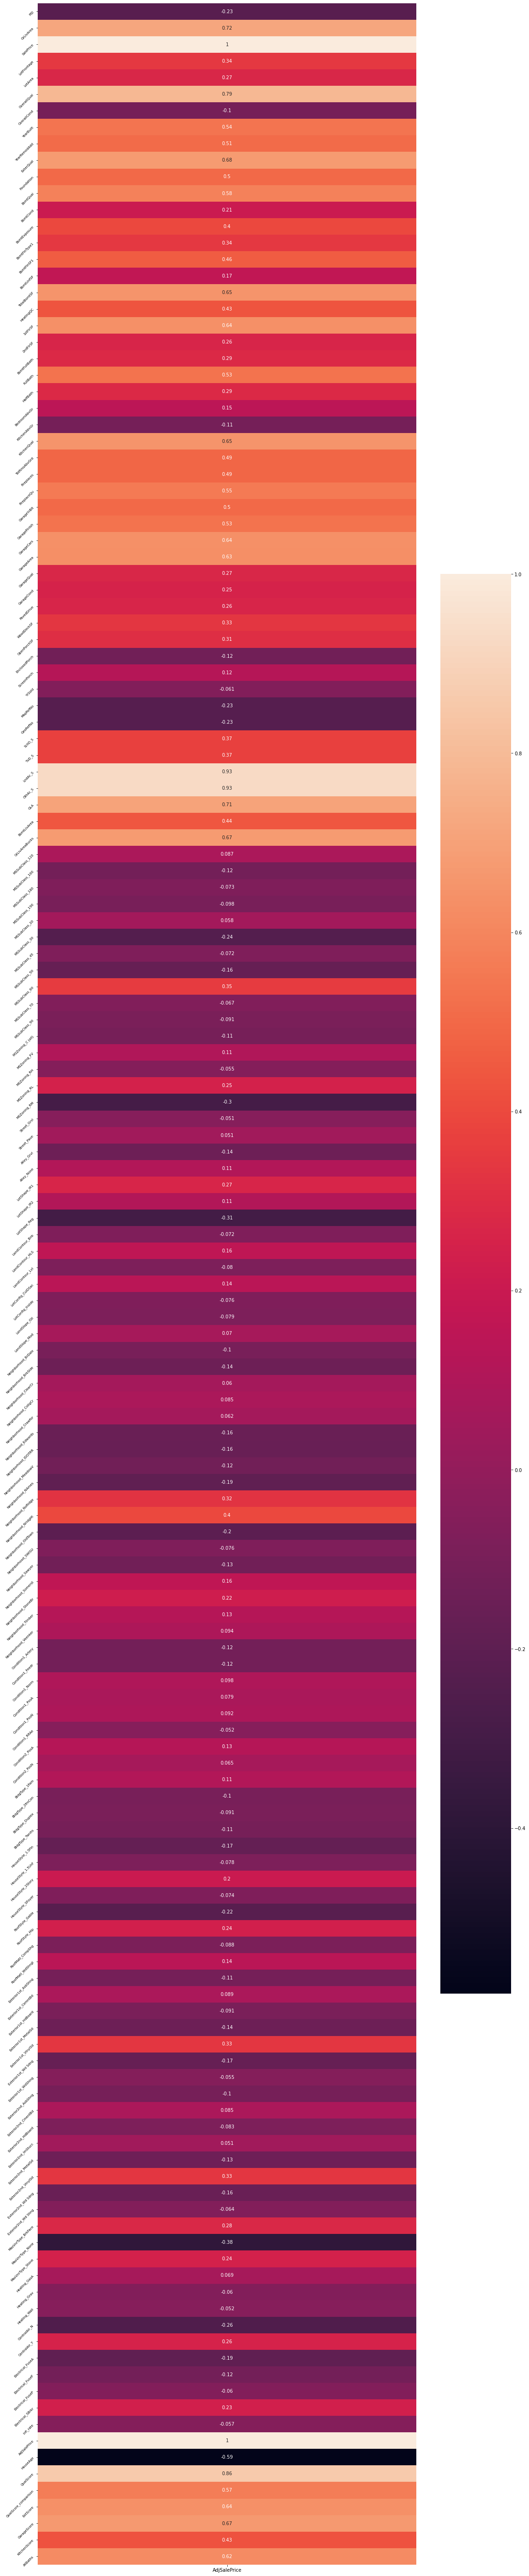

In [59]:
# add in a few other features to housing4, see how it tweaks score
# need to clean up the rest of the dataset

def OneBarHeatmap(data,keyfeature,upperbound,lowerbound):
	# This function charts a single column heatmap, with one corresponding variable (keyfeature). The keyfeature is shown on the xaxis with the input variables shown on the yaxis. Data input should be in dataframe (df) format. Upperbound and lowerbound are taken as decimals.

	dataframe = data.corr()[(data.corr() > upperbound) | (data.corr() < lowerbound)][[keyfeature]].dropna()
	width, height = 18, 100

	xticks, k, j = dataframe.index, 45, 7
	yticks = data[[keyfeature]].columns[::]
	plt.subplots(figsize=(width, height))
	sns.heatmap(dataframe,annot=True)

	plt.yticks(rotation=k,fontsize=j)
	CorrframeOne = dataframe[::]
	plt.show()

	return CorrframeOne

Corr = OneBarHeatmap(housing3, 'AdjSalePrice', 0.05, -0.05)